Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [3]:
# Importing all the important libraries


import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from glob import glob

In [4]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [12]:
print(data_dir_train)

/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [13]:
# total number of images under train and test

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Create a dataset

Define some parameters for the loader:




In [14]:
batch_size = 32
img_height = 180
img_width = 180

Preparing Dataset for the training


Use 80% of the images for training, and 20% for validation. seed = 123

**1. training dataset**

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, seed=123,
                                                               batch_size=batch_size,
                                                               image_size=(img_width, img_height),
                                                               validation_split=0.2,
                                                               subset="training")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**2. validation dataset**

In [16]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_test, seed=123,
                                                               batch_size=batch_size,
                                                               image_size=(img_width, img_height),
                                                               validation_split=0.2,
                                                               subset="validation")

Found 118 files belonging to 9 classes.
Using 23 files for validation.


Visualize the data


 To visualize one instance of all the nine classes present in the dataset

In [17]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Drawing the images from each class

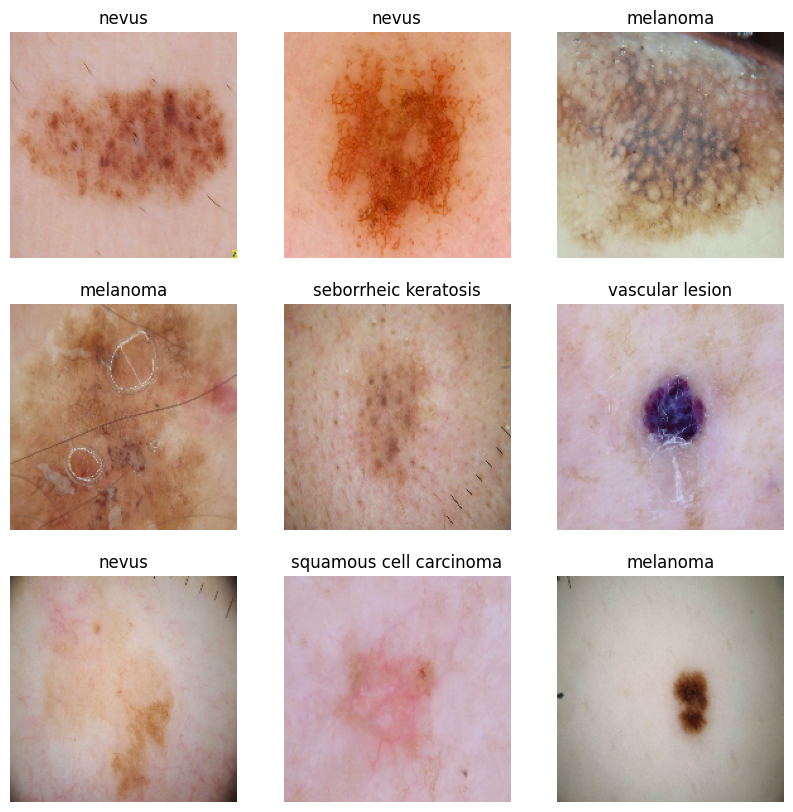

In [18]:
# Set the figure size
plt.figure(figsize=(10, 10))

# Loop through the first 2 batches of images and labels in the training dataset
for images, labels in train_ds.take(2):
    # Loop through each image in the batch (maximum of 9 images)
    for i in range(min(9, len(images))):
        # Create a subplot within the figure grid
        ax = plt.subplot(3, 3, i + 1)

        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot as the corresponding class name
        plt.title(class_names[labels[i]])

        # Turn off axis ticks
        plt.axis("off")

# Display the figure
plt.show()

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

## **1. Simple Model - 3 ConvLayers, Kernels at each layer = (16, 32, 64)**

 a CNN model, which can accurately detect 9 classes present in the dataset.

 layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [34]:
num_classes = 9

model_simple = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
model_simple.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
# Compile the model before training
model_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
epochs = 20
history = model_simple.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 225s 123ms/step - loss: 12.9097 - accuracy: 0.1914 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0435
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 12.9520 - accuracy: 0.1964 - val_loss: 15.4173 - val_accuracy: 0.0

Observations:

The training and validation accuracies are quite low and do not seem to improve significantly over epochs.
The loss values are also quite high and do not show substantial improvement, which suggests that the model might not be learning effectively.
The training and validation accuracies being close to each other could indicate that the model is not overfitting, but it is not learning the patterns in the data well either.

with only around 20% training accuracy and 4% validation accuracy. To improve the model's performance for image classification, adding more layers can be a good approach. Adding more layers can increase the model's capacity to learn complex patterns in the data.

## **2. Trying of complex model, Kernels at each layer = (32, 32, 64, 64); Kernel size = 3x3**
**- 4 ConvLayers with BatchNormalization and w/o DropOut Layers **

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [16]:
num_classes = 9
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [18]:
# Compile the model before training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 13s 116ms/step - loss: 25.8741 - accuracy: 0.3075 - val_loss: 51.0719 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0498 - accuracy: 0.3209 - val_loss: 78.6726 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7301 - accuracy: 0.3834 - val_loss: 93.4982 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 6s 100ms/step - loss: 1.5681 - accuracy: 0.4314 - val_loss: 99.0356 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 6s 99ms/step - loss: 1.4612 - accuracy: 0.4799 - val_loss: 103.7295 - val_accuracy: 0.0870
Epoch 6/20
56/56 [==============================] - 6s 99ms/step - loss: 1.3992 - accuracy: 0.4632 - val_loss: 63.9536 - val_accuracy: 0.0870
Epoch 7/20
56/56 [==============================] - 6s 98ms/step - loss: 1.2770 - accuracy: 0.5112 - val_loss: 37.7240 - val_accuracy: 0.1304
E

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                     

**Visualizing training** **results**

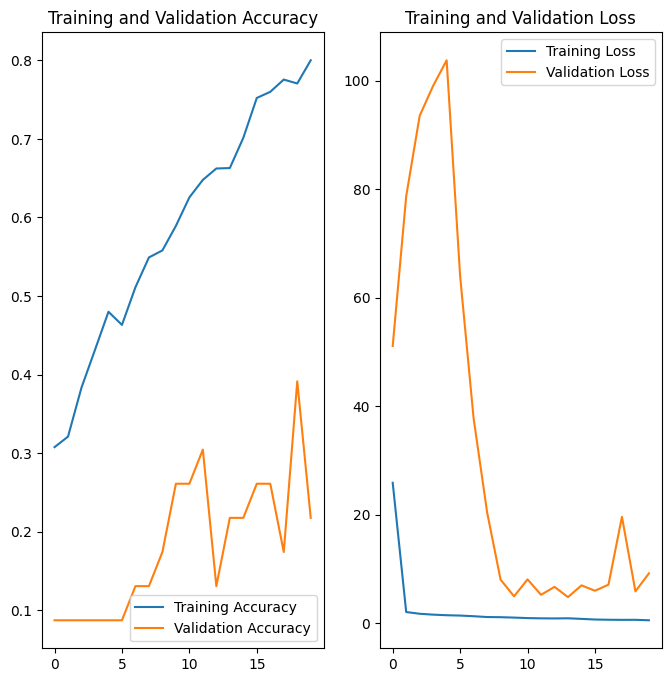

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**findings**
it seems like the model is indeed overfitting as indicated by the high training accuracy (0.89) compared to the low validation accuracy (0.36) after 20 epochs.

## **3.Using DropOut layer in the model**
Kernels at each layer = (32, 32, 64, 64); Kernel size = 3x3

In [22]:
num_classes = 9
model_do = Sequential()
model_do.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(Conv2D(32, (3, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(MaxPooling2D(pool_size=(2, 2)))
#model_do.add(Dropout(0.25))

model_do.add(Conv2D(64, (3, 3), padding='same'))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(Conv2D(64, (3, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(MaxPooling2D(pool_size=(2, 2)))
#model_do.add(Dropout(0.25))

model_do.add(Flatten())
model_do.add(Dense(512))
model_do.add(Activation('relu'))
model_do.add(Dropout(0.2))
model_do.add(Dense(num_classes))
model_do.add(Activation('softmax'))

In [23]:
model_do.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [24]:
# Compile the model before training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
epochs = 20
history = model_do.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 7s 97ms/step - loss: 3.0341 - accuracy: 0.3633 - val_loss: 3.5558 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 1.3873 - accuracy: 0.5218 - val_loss: 5.0871 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 1.1020 - accuracy: 0.6217 - val_loss: 7.2530 - val_accuracy: 0.1304
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 0.8426 - accuracy: 0.7020 - val_loss: 6.4250 - val_accuracy: 0.1304
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 0.5930 - accuracy: 0.7969 - val_loss: 7.0016 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 0.4008 - accuracy: 0.8583 - val_loss: 5.3455 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 0.3240 - accuracy: 0.8783 - val_loss: 4.2922 - val_accuracy: 0.2174
Epoch 8/20
56

### 6 ConvLayers with dropout factors = 0.25 at every ConvLayer and 0.5 at the **final DNN layer**
## **Kernels at each layer = (32, 32, 64, 64, 128, 128); Kernel size = 3x3 **

In [26]:
model_ml = Sequential()
model_ml.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(32, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Conv2D(64, (3, 3), padding='same'))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(64, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Conv2D(128, (3, 3), padding='same'))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(128, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Flatten())
model_ml.add(Dense(512,kernel_regularizer=l2(0.01)))
model_ml.add(Activation('relu'))
model_ml.add(Dropout(0.5))
model_ml.add(Dense(num_classes))
model_ml.add(Activation('softmax'))

In [27]:
model_ml.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [28]:
epochs = 20
history_ml = model_ml.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 12s 165ms/step - loss: 14.2887 - accuracy: 0.3041 - val_loss: 13.6764 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 9s 157ms/step - loss: 11.5426 - accuracy: 0.4057 - val_loss: 13.6686 - val_accuracy: 0.2174
Epoch 3/20
56/56 [==============================] - 9s 156ms/step - loss: 11.1341 - accuracy: 0.4855 - val_loss: 15.2457 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 9s 157ms/step - loss: 10.8067 - accuracy: 0.5223 - val_loss: 14.9335 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 9s 158ms/step - loss: 10.5045 - accuracy: 0.5686 - val_loss: 14.9106 - val_accuracy: 0.0435
Epoch 6/20
56/56 [==============================] - 9s 158ms/step - loss: 10.2006 - accuracy: 0.6010 - val_loss: 14.7334 - val_accuracy: 0.1304
Epoch 7/20
56/56 [==============================] - 9s 158ms/step - loss: 9.9121 - accuracy: 0.6334 - val_loss: 13.5430 - val_accuracy:

> Inference - Even with the model with more number of convolution layers, the validation accuracy is not that good - about 0.3

**Distribution of classes in the files**

<Figure size 3000x800 with 0 Axes>

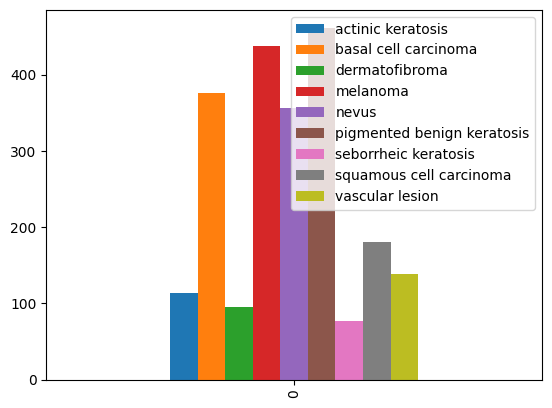

In [29]:
image_ct_dict = {}
for c_name in class_names:
    image_ct_dict[c_name] = len(list(data_dir_train.glob(c_name + '/*.jpg')))

df = pd.DataFrame([image_ct_dict])
plt.figure(figsize=(30, 8))
df.plot.bar()
plt.show()

In [7]:
pip install Augmentor

**Augmentor** **approach**

In [19]:
path_to_training_dataset = str(data_dir_train) + "/"
print(path_to_training_dataset)
# Instantiate a Pipeline object pointing to a directory containing your initial image data set.
# Define a number of operations to perform on this data set using your Pipeline object.
# Execute these operations by calling the Pipeline’s sample() method.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79563C642E90>: 100%|██████████| 500/500 [00:18<00:00, 26.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7956454BAB60>: 100%|██████████| 500/500 [00:19<00:00, 25.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7956460A6290>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7956460A4D60>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x79563E7BD660>: 100%|██████████| 500/500 [01:16<00:00,  6.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7956E4B6E800>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79563C48CB80>: 100%|██████████| 500/500 [00:38<00:00, 13.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79563C601C60>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79563C4F1930>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [25]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025973.jpg_6a9fcc1c-8e39-4233-b682-a22f6bbda2cb.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027470.jpg_94496b53-0599-4971-b32a-882c5d4f11f4.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024981.jpg_155dc0a3-fb9e-4ea5-bd31-9f6356ff1296.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028236.jpg_1383dea4-7217-4932-aa25-87c4cb27225b.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benig

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
dataframe_dict_new

{'/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025973.jpg_6a9fcc1c-8e39-4233-b682-a22f6bbda2cb.jpg': 'pigmented benign keratosis',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027470.jpg_94496b53-0599-4971-b32a-882c5d4f11f4.jpg': 'pigmented benign keratosis',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024981.jpg_155dc0a3-fb9e-4ea5-bd31-9f6356ff1296.jpg': 'pigmented benign keratosis',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028236.jpg_1383dea4-7217-4932-aa25-87c4cb27225b.jpg': 'pigmented benign 

In [29]:
data2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [30]:
data2['Label'].value_counts()

pigmented benign keratosis    1000
seborrheic keratosis          1000
vascular lesion               1000
dermatofibroma                1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
melanoma                      1000
nevus                         1000
Name: Label, dtype: int64

**So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.**

# **Train the model on the data created using Augmentor**

In [31]:
data_dir_train_aug= data_dir_train
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [32]:
valid_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


**Model considering augmented data as well**

In [37]:
model_ml_aug = Sequential()
model_ml_aug.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(32, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Conv2D(64, (3, 3), padding='same'))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(64, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Conv2D(128, (3, 3), padding='same'))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(128, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Flatten())
model_ml_aug.add(Dense(512,kernel_regularizer=l2(0.01)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(Dropout(0.5))
model_ml_aug.add(Dense(num_classes))
model_ml_aug.add(Activation('softmax'))

In [38]:
model_ml_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [41]:
epochs = 20
history_ml_aug = model_ml_aug.fit(
  train_ds_aug,
  validation_data=valid_ds_aug,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
281/281 [==============================] - 80s 282ms/step - loss: 0.5072 - accuracy: 0.9397 - val_loss: 0.6166 - val_accuracy: 0.9101
Epoch 2/20
281/281 [==============================] - 73s 256ms/step - loss: 0.4989 - accuracy: 0.9414 - val_loss: 0.5946 - val_accuracy: 0.9146
Epoch 3/20
281/281 [==============================] - 73s 255ms/step - loss: 0.5077 - accuracy: 0.9342 - val_loss: 0.6224 - val_accuracy: 0.9070
Epoch 4/20
281/281 [==============================] - 73s 255ms/step - loss: 0.4850 - accuracy: 0.9431 - val_loss: 0.6274 - val_accuracy: 0.9003
Epoch 5/20
281/281 [==============================] - 73s 254ms/step - loss: 0.4647 - accuracy: 0.9461 - val_loss: 0.6029 - val_accuracy: 0.9025
Epoch 6/20
281/281 [==============================] - 71s 249ms/step - loss: 0.4587 - accuracy: 0.9426 - val_loss: 0.6108 - val_accuracy: 0.8941
Epoch 7/20
281/281 [==============================] - 73s 257ms/step - loss: 0.4509 - accuracy: 0.9448 - val_loss: 0.5968 - val_ac

In [42]:
model_ml_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_8 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_7 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                     

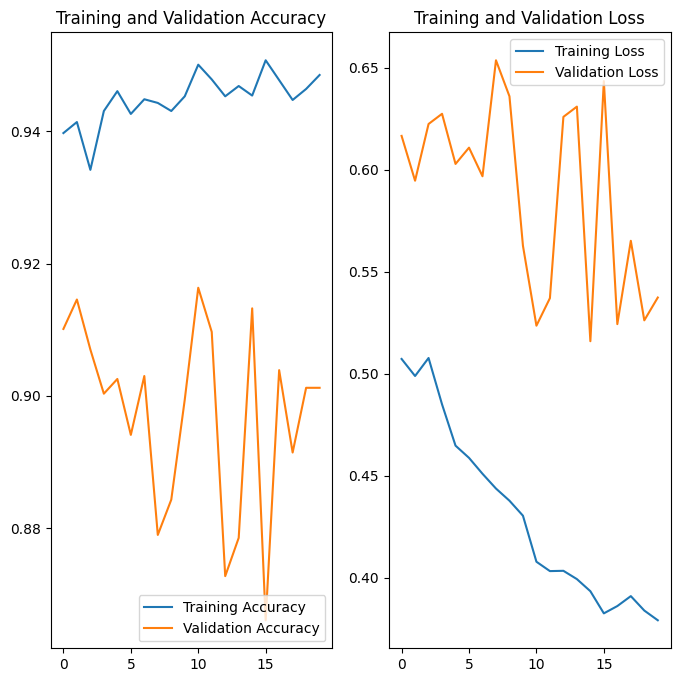

In [43]:
acc_aug = history_ml_aug.history['accuracy']
val_acc_aug = history_ml_aug.history['val_accuracy']

loss_aug = history_ml_aug.history['loss']
val_loss_aug = history_ml_aug.history['val_loss']

epochs_range_aug = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_aug, acc_aug, label='Training Accuracy')
plt.plot(epochs_range_aug, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_aug, loss_aug, label='Training Loss')
plt.plot(epochs_range_aug, val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Conclusion**

1. **Overfitting and Imbalanced Data:**

  Overfitting tends to occur notably when the dataset is imbalanced.
  Models trained on imbalanced data exhibit varied behaviors:
  Model.1: Shows underfitting with low training and validation accuracies.

  Model.2 and Model.3: Exhibit clear signs of overfitting with high training accuracies but significantly lower validation accuracies.

  Model.3 incorporates an additional dropout layer but still demonstrates overfitting, suggesting that tweaking dropout factors or adding more layers might mitigate overfitting to some extent.

  Model.4 shows decent performance with intermediate dropout layers, indicating that adding more layers with additional dropout layers might not significantly enhance performance but can reduce training time.

2. **Impact of Data Augmentation:**

  Augmentation helps in balancing the dataset, mitigating the effects of imbalance.

  Model.4, when trained on augmented data, shows improved performance:
  Training accuracy remains high at above 92%.
  Validation accuracy significantly improves to 88%.